Replicate EV/REV plots for Octopamine/Rolipram sessions previously generated by Jahangir.

In [55]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform
import scipy.stats as stats

import subjects

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
    sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy.core.neurons import Neurons
from neuropy.analyses.reactivation import ExplainedVariance
from neuropy.core.epoch import Epoch
from neuropy.core.session import ProcessData
from neuropy.plotting import plot_epochs, Fig
from neuropy.utils.plot_util import match_axis_lims

from plotters import Plotter
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

import ev_utils

grp_data_dir = Path("/data3/Octopamine_Rolipram/GroupData")
plot_save_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_octopamine_rollipram/Nat_plots')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up colors and rough injection times (from Jahangir plots)

In [2]:
sesh_csv = "/data3/Octopamine_Rolipram/Recording_Rats/OCT_ROL_sessions.csv"
sesh_df = pd.read_csv(sesh_csv, header=0)
sesh_df['session'] = pd.Categorical(sesh_df['session'], ['PBS', 'SAL', 'ROL', 'OCT'])
sesh_df = sesh_df.sort_values(["Animal", "session"]).reset_index().drop(columns = "index")
sesh_df

,Animal,session,date,directory,processed,inject 1,inject 2,accuracy
0,A11,PBS,2019_12_02,/data3/Octopamine_Rolipram/Recording_Rats/A11/...,Y,4.8,6.3,guess
1,A11,ROL,2019_12_12,/data3/Octopamine_Rolipram/Recording_Rats/A11/...,Y,4.8,6.3,guess
2,A11,OCT,2019_11_30,/data3/Octopamine_Rolipram/Recording_Rats/A11/...,Y,4.8,6.3,guess
3,A14,PBS,2020_02_23,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y,4.7,6.2,from_plot
4,A14,ROL,2020_02_26,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y,5.0,6.5,from_plot
5,A14,OCT,2020_02_21,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y,4.8,6.3,guess
6,BG,SAL,2019_10_21,/data3/Octopamine_Rolipram/Recording_Rats/BG/B...,Y,4.8,6.3,from_plot
7,BG,ROL,2019_10_19,/data3/Octopamine_Rolipram/Recording_Rats/BG/B...,Y,4.9,6.4,from_plot
8,BG,OCT,None,None,N,NaN,NaN,NaN
9,BGU,SAL,2021_08_11,/data3/Octopamine_Rolipram/Recording_Rats/BGU/...,Y,4.7,6.2,from_plot


In [39]:
colors_rs = "#5599ff"
colors_nsd = "k"
colors_sd = "#eb4034"
colors_maze = "g"
colors_pre = "#424242"
colors_sd_all = [colors_pre, colors_maze, colors_sd, colors_rs]

def adjust_lightness(color, amount=0.5):
    import colorsys

    import matplotlib.colors as mc

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    c = colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    return mc.to_hex(c)

colors_all_light = [adjust_lightness(col, 1.2) for col in colors_sd_all]
colors_grp = [colors_sd, colors_pre]
colors_grp_light = [adjust_lightness(col, 1.2) for col in colors_grp]

## Bootstrap sessions

First calculate pairwise correlations for each session

In [ ]:
# Update sesh_df to have same term for controls
sesh_df["session_type"] = sesh_df.session.apply(lambda session_id: 'PBS/SAL' if session_id in ["PBS", "SAL"] else session_id)

pcorr_df = []
sub = 0
for session_type in ["PBS/SAL", "ROL"]:
    sesh_type_df = sesh_df[sesh_df.session_type == session_type]
    for ida, animal in enumerate(sesh_type_df.Animal.unique()):
        rec_df = sesh_type_df[sesh_type_df.Animal == animal]
        if (rec_df.directory.values[0] == "None") or (rec_df.processed.values[0] == "N"):
            pass
        else:
            dir_use = Path(str(rec_df["directory"].values[0]))
            neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
            neurons_use = neurons_use.get_neuron_type(["pyr", "good", "1"])
            epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])

            # Make epochs class with PRE, MAZE, 0-2.5, 2.5-5, and 5-7.5
            blk1 = [epochs["sd"].starts[0], epochs["sd"].starts[0] + 3600*2.5, "0-2.5", np.nan]
            blk2 = [epochs["sd"].starts[0] + 3600*2.5, epochs["sd"].starts[0] + 3600*5, "2.5-5", np.nan]
            blk3 = [epochs["sd"].stops[0], epochs["post"].starts[0] + 3600*2.5, "5-7.5", np.nan]
            epochs_df = deepcopy(epochs.to_dataframe())
            for blk in [blk1, blk2, blk3]:
                epochs_df.loc[-1] = blk
                epochs_df.index = epochs_df.index + 1  # shifting index
                epochs_df = epochs_df.sort_index() 
            for lcasename in ["pre", "post", "sd", "maze"]:
                epochs_df.loc[epochs_df.label == lcasename, "label"] = lcasename.upper()
            zt_epochs = Epoch(epochs_df)[["PRE", "MAZE", "0-2.5", "2.5-5", "5-7.5"]]
            
            pcorr, labels = ev_utils.get_pcorr(neurons=neurons_use, epochs=zt_epochs)
            df = pd.DataFrame(data=pcorr, columns=labels)
        
            df["session"] = sub
            sub += 1
            df["grp"] = session_type
            pcorr_df.append(df)

pcorr_df = pd.concat(pcorr_df, ignore_index=True)
np.save(grp_data_dir / "pcorrs.npy", pcorr_df, allow_pickle=True)

Now bootstrap them!

In [ ]:
from stats_utils import bootstrap_resample
from ev_utils import get_ev, get_ev_mean

# Remove sessions with less than specified number of pairs!
count_df = pcorr_df.groupby("session").count().reset_index()
npairs_thresh = 2
good_sesh = count_df["session"][count_df["grp"] >= npairs_thresh]
good_sesh_bool = pcorr_df.session.apply(lambda x: x in good_sesh)

kw = dict(df=pcorr_df[good_sesh_bool], n_iter=10000, n_jobs=10)

boot_df = bootstrap_resample(level="both", apply=get_ev, **kw)
boot_save_append = f"_min{npairs_thresh}pairs"
np.save(f"/data3/Octopamine_Rolipram/GroupData/ev_in_chunks_bootstrap{boot_save_append}.npy", boot_df, allow_pickle=True)

In [ ]:
fig, ax = plt.subplots()
p1 = Plotter(data=boot_df, x="zt", y="ev", hue="grp", hue_order=["PBS/SAL", "ROL"], ax=ax)
p1.boxplot_sd2(legend=False)

df_use = df_comb[df_comb.session != "OCT"]
df_use = df_use[df_use.npairs > npairs_thresh]
# sns.stripplot(data=df_use, x="block", y="ev_mean", hue="session", dodge=True, 
#               edgecolor="w", linewidth=0.2, ax=ax)
# palette_light = subjects.colors_sd_light(1)
p2 = Plotter(data=ev_df, x="zt", y="ev", hue="grp", hue_order=["NSD", "SD"])
p2.striplineplot_sd()


fig.savefig(plot_save_dir / f"ROL_v_SAL_ev_in_blocks{boot_save_append}.pdf")

## Calculate EV in chunks and plot with bootstrapped values


In [4]:
ev_dict_all3 = np.load("/data3/Octopamine_Rolipram/GroupData/ev_comb_pyr_only_wave_exclude.npy", allow_pickle=True).item()

In [5]:
# session_id = "A11_ROL"
# ev_use = ev_dict_all3[session_id]
df_comb = []
n = 0
for session_id, ev_use in ev_dict_all3.items():
    type = 'PBS/SAL' if session_id.split("_")[1] in ["PBS", "SAL"] else session_id.split("_")[1]
    animal = session_id.split("_")[0]
    t_bins_hrs = (ev_use.matching_time - ev_use.matching_time[0])/3600
    tlims = [[0, 2.5], [2.5, 5.0], [5.0, 7.5]]
    

    for tlim, tlabel in zip(tlims, ["0-2.5", "2.5-5", "5-7.5"]):
        tbool = (t_bins_hrs >= tlim[0]) & (t_bins_hrs < tlim[1])
        ev_mean = np.mean(ev_use.ev[tbool])
        df_comb.append(pd.DataFrame({"block": tlabel, "ev_mean": ev_mean, "animal": animal, "session": type,
                                     "npairs": ev_use.n_pairs}, index=[n]))
        n += 1
df_comb = pd.concat(df_comb, axis=0)
np.save(grp_data_dir / "ev_in_chunks.npy", df_comb, allow_pickle=True)

df_comb.head(6)

,block,ev_mean,animal,session,npairs
0,0-2.5,0.397364,A11,PBS/SAL,21
1,2.5-5,0.460640,A11,PBS/SAL,21
2,5-7.5,0.328227,A11,PBS/SAL,21
3,0-2.5,NaN,A11,ROL,1
4,2.5-5,NaN,A11,ROL,1
5,5-7.5,NaN,A11,ROL,1


In [28]:
boot_df.head(5)

,zt,ev,grp
0,0-2.5,0.087229,PBS/SAL
1,2.5-5,0.053733,PBS/SAL
2,5-7.5,0.06135,PBS/SAL
3,0-2.5,0.098895,PBS/SAL
4,2.5-5,0.059382,PBS/SAL


In [67]:
df_comb.head(5)

,zt,ev,session,grp,npairs
0,0-2.5,0.397364,A11,PBS/SAL,21
1,2.5-5,0.46064,A11,PBS/SAL,21
2,5-7.5,0.328227,A11,PBS/SAL,21
3,0-2.5,NaN,A11,ROL,1
4,2.5-5,NaN,A11,ROL,1


In [32]:
df_use

,block,ev_mean,Animal,session,npairs
9,0-2.5,0.062138,A14,PBS/SAL,4473
10,2.5-5,0.048141,A14,PBS/SAL,4473
11,5-7.5,0.059013,A14,PBS/SAL,4473
12,0-2.5,0.055183,A14,ROL,18765
13,2.5-5,0.044757,A14,ROL,18765
14,5-7.5,0.023105,A14,ROL,18765
18,0-2.5,0.057623,BG,PBS/SAL,2087
19,2.5-5,0.063611,BG,PBS/SAL,2087
20,5-7.5,0.095294,BG,PBS/SAL,2087
21,0-2.5,0.027813,BG,ROL,2577


/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths/plotters.py:217: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,


p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

2.5-5_PBS/SAL vs. 2.5-5_ROL: get_bootstrap_prob, P_val:1.688e-01 Stat=1.386e+00
0-2.5_PBS/SAL vs. 0-2.5_ROL: get_bootstrap_prob, P_val:6.075e-03 Stat=2.963e+00
5-7.5_PBS/SAL vs. 5-7.5_ROL: get_bootstrap_prob, P_val:4.840e-01 Stat=1.466e-01
0-2.5_PBS/SAL vs. 5-7.5_ROL: get_bootstrap_prob, P_val:2.228e-01 Stat=9.149e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

0-2.5_PBS/SAL vs. 2.5-5_PBS/SAL: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=3.778e-02
2.5-5_PBS/SAL vs. 5-7.5_PBS/SAL: get_bootstrap_prob_paired, P_val:2.735e-01 Stat=-1.189e-02
0-2.5_PBS/SAL vs. 5-7.5_PBS/SAL: get_bootstrap_prob_paired, P_val:4.510e-02 Stat=2.590e-02
p-value annotation leg

/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths/plotters.py:366: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,


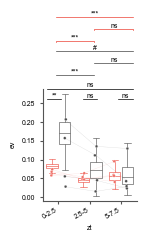

In [69]:
npairs_thresh = 100
boot_save_append = f"_min{npairs_thresh}pairs"
# df_comb = np.load(grp_data_dir / "ev_in_chunks.npy", allow_pickle=True).item()[0]
df_comb = pd.DataFrame(np.load(grp_data_dir / "ev_in_chunks.npy", allow_pickle=True),
                       columns=["zt", "ev", "Animal", "grp", "npairs"])
boot_df = pd.DataFrame(np.load(grp_data_dir / f"ev_in_chunks_bootstrap{boot_save_append}.npy", allow_pickle=True), 
                       columns=["zt", "ev", "grp"])

# fig, ax = plt.subplots()
fig = subjects.SdFig().fig3()
ax = fig.subplot(fig.gs[:2, 4])
p1 = Plotter(data=boot_df, x="zt", y="ev", hue="grp", hue_order=["PBS/SAL", "ROL"], ax=ax)
p1.boxplot_sd2(legend=True, palette=colors_grp).stat_anot_sd(
    stat_within=get_bootstrap_prob_paired,
    stat_across=get_bootstrap_prob,
    alpha_across=[0.05, 0.01, 0.001],
    alpha_within=[0.025, 0.005, 0.0005],
    fontsize=5,
    pair_names=["PBS/SAL", "ROL"],
    verbose=True,
)

df_use = df_comb[df_comb.grp != "OCT"]
df_use = df_use[df_use.npairs > npairs_thresh]
# sns.stripplot(data=df_use, x="block", y="ev_mean", hue="session", dodge=True, 
#               edgecolor="w", linewidth=0.2, ax=ax)
p2 = Plotter(data=df_use, x="zt", y="ev", hue="grp", hue_order=["PBS/SAL", "ROL"], ax=ax)
p2.striplineplot_sd(palette=colors_grp_light, units="Animal")
# p2.striplineplot_sd()

fig.savefig(plot_save_dir / f"ROL_v_SAL_ev_in_blocks{boot_save_append}.pdf")

## Power Analysis
1) Calculate weighted mean and std due to vast differences in # of neuron-pairs.
2) Do brute force power analysis by adding in an additional animal to each group until you get p < 0.05 for first block and then for second block

In [60]:
# Define lambda functions to get weighted mean and standard deviation
from statsmodels.stats.weightstats import DescrStatsW
weighted_mean = lambda df: DescrStatsW(df.ev_mean, weights=df.npairs, ddof=0).mean
weighted_std = lambda df: DescrStatsW(df.ev_mean, weights=df.npairs, ddof=0).std

In [61]:
ev_sd_stats = ev_sd.drop(columns=["rev", "ev_diff", "ev_perc", "session", "name", "sex"]).groupby(["grp", "zt"]).count().rename(columns={"ev": "n"}).reset_index()
ev_sd_stats["ev_mean"] = ev_sd.groupby(["grp", "zt"]).mean(numeric_only=True).reset_index()["ev"]
ev_sd_stats["ev_std"] = ev_sd.groupby(["grp", "zt"]).std(numeric_only=True).reset_index()["ev"]
ev_sd_stats

,grp,zt,n,ev_mean,ev_std
0,NSD,0-2.5,6,0.155618,0.084213
1,NSD,2.5-5,6,0.067306,0.035342
2,NSD,5-7.5,6,0.073258,0.085710
3,SD,0-2.5,7,0.074081,0.081213
4,SD,2.5-5,7,0.016285,0.016965
5,SD,5-7.5,7,0.037279,0.004609


In [90]:
import itertools
def get_tstats_win_grp(df_in, grp, zt_list = ["0-2.5", "2.5-5", "5-7.5"]):
    """Calculate within group stats"""
    tstat = []
    cohen_d = []
    dof = []
    pval = []
    blk0_mean, blk1_mean = [], []
    blk0, blk1 = [], []
    
    df_use = df_in[df_in.grp == grp]
    for zt0, zt1 in itertools.combinations(zt_list, 2):
        
        df_grp0 = df_use[df_use.zt == zt0].reset_index()
        df_grp1 = df_use[df_use.zt == zt1].reset_index()

        tstat.append(((df_grp0.ev_mean - df_grp1.ev_mean) / 
                      np.sqrt(df_grp0.ev_std ** 2 / df_grp0.n + df_grp1.ev_std ** 2 / df_grp1.n))
                     .values[0])
        cohen_d.append(((df_grp0.ev_mean - df_grp1.ev_mean) / 
                      np.sqrt(((df_grp0.n - 1) * df_grp0.ev_std ** 2 + (df_grp1.n - 1) * df_grp1.ev_std ** 2 ) / (df_grp0.n + df_grp1.n)))
                      .values[0])
        
        dof.append(((df_grp0.ev_std ** 2 / df_grp0.n + df_grp1.ev_std ** 2 / df_grp1.n) ** 2 / 
                   (df_grp0.ev_std ** 4 / (df_grp0.n ** 2) / (df_grp0.n - 1) + df_grp1.ev_std ** 4 / (df_grp1.n ** 2) / (df_grp1.n - 1))).values[0])
        pval.append(2 * (1 - stats.t.cdf(np.abs(tstat[-1]), dof[-1])))
        blk0.append(zt0)
        blk1.append(zt1)
        blk0_mean.append(df_grp0.ev_mean.values[0])
        blk1_mean.append(df_grp1.ev_mean.values[0])
        
    return pd.DataFrame({"grp": grp, "block0": blk0, "block1": blk1 , "block0_mean": blk0_mean, "block1_mean": blk1_mean,
                         "tstat": tstat, "dof": dof, "pval": pval, "Cohens-d": cohen_d})
get_tstats_win_grp(ev_sd_stats, "NSD")

,grp,block0,block1,block0_mean,block1_mean,tstat,dof,pval,Cohens-d
0,NSD,0-2.5,2.5-5,0.155618,0.067306,2.368581,6.708270,0.051244,1.498022
1,NSD,0-2.5,5-7.5,0.155618,0.073258,1.678949,9.996898,0.124096,1.061861
2,NSD,2.5-5,5-7.5,0.067306,0.073258,-0.157259,6.652516,0.879707,-0.099459


In [65]:
def get_tstats(df_in, grps = ["NSD", "SD"], zt_list = ["0-2.5", "2.5-5", "5-7.5"]):
    """Handwritten function to get t-stats, checks out with scipy.stats"""
    tstat = []
    cohen_d = []
    dof = []
    pval = []
    grp0_mean, grp1_mean = [], []
    for zt in zt_list:
        df_use = df_in[df_in.zt == zt]
        df_grp0 = df_use[df_use.grp == grps[0]].reset_index()
        df_grp1 = df_use[df_use.grp == grps[1]].reset_index()
        tstat.append(((df_grp0.ev_mean - df_grp1.ev_mean) / 
                      np.sqrt(df_grp0.ev_std ** 2 / df_grp0.n + df_grp1.ev_std ** 2 / df_grp1.n))
                     .values[0])
        cohen_d.append(((df_grp0.ev_mean - df_grp1.ev_mean) / 
                      np.sqrt(((df_grp0.n - 1) * df_grp0.ev_std ** 2 + (df_grp1.n - 1) * df_grp1.ev_std ** 2 ) / (df_grp0.n + df_grp1.n)))
                      .values[0])
        
        dof.append(((df_grp0.ev_std ** 2 / df_grp0.n + df_grp1.ev_std ** 2 / df_grp1.n) ** 2 / 
                   (df_grp0.ev_std ** 4 / (df_grp0.n ** 2) / (df_grp0.n - 1) + df_grp1.ev_std ** 4 / (df_grp1.n ** 2) / (df_grp1.n - 1))).values[0])
        pval.append(2 * (1 - stats.t.cdf(np.abs(tstat[-1]), dof[-1])))
        grp0_mean.append(df_grp0.ev_mean.values[0])
        grp1_mean.append(df_grp1.ev_mean.values[0])
        
    return pd.DataFrame({"zt": zt_list, f"{grps[0]}mean": grp0_mean, f"{grps[1]}mean": grp1_mean,
                         "tstat": tstat, "dof": dof, "pval": pval, "Cohens-d": cohen_d})

get_tstats(ev_sd_stats)

,zt,NSDmean,SDmean,tstat,dof,pval,Cohens-d
0,0-2.5,0.155618,0.074081,1.769123,10.557909,0.105707,1.073253
1,2.5-5,0.067306,0.016285,3.231385,6.944417,0.014583,2.060281
2,5-7.5,0.073258,0.037279,1.026975,5.024794,0.351305,0.675704


In [72]:
df_comb.sample(5)

,zt,ev,Animal,grp,npairs
32,5-7.5,0.040111,MR10,PBS/SAL,4341
16,2.5-5,NaN,A14,OCT,9
18,0-2.5,0.057623,BG,PBS/SAL,2087
34,2.5-5,0.111343,MR10,ROL,3589
8,5-7.5,0.099352,A11,OCT,42


In [74]:
# Get t-stats for Rolipram
df_comb = pd.DataFrame(np.load(grp_data_dir / "ev_in_chunks.npy", allow_pickle=True),
                       columns=["zt", "ev_mean", "session", "grp", "npairs"])
df_comb = df_comb[df_comb.grp != "OCT"]
df_comb["ev_mean"] = df_comb["ev_mean"].astype("float")
df_rol_stats = df_comb[~np.isnan(df_comb.ev_mean)].groupby(["grp", "zt"]).apply(weighted_mean).reset_index().rename(columns={0: "ev_mean"})
df_rol_stats["ev_std"] = df_comb[~np.isnan(df_comb.ev_mean)].groupby(["grp", "zt"]).apply(weighted_std).reset_index()[0]
df_rol_stats["n"] = df_comb[~np.isnan(df_comb.ev_mean)].groupby(["grp", "zt"]).count().reset_index()["ev_mean"]
df_rol_stats

,grp,zt,ev_mean,ev_std,n
0,PBS/SAL,0-2.5,0.069019,0.011836,5
1,PBS/SAL,2.5-5,0.050375,0.013777,5
2,PBS/SAL,5-7.5,0.057756,0.016456,5
3,ROL,0-2.5,0.131026,0.075346,4
4,ROL,2.5-5,0.089563,0.046148,4
5,ROL,5-7.5,0.073428,0.051622,4


In [89]:
# Iterate through, adding an additional animal to each group and calculate tstat and pvalue assuming the same mean and variance
from copy import deepcopy
df_iter = []
for n in np.arange(0, 5, 1):
    df_use = deepcopy(df_rol_stats)
    df_use["n"] = df_use["n"] + n
    nsal = df_use[df_use.grp == "PBS/SAL"]["n"].values[0]
    nrol = df_use[df_use.grp == "ROL"]["n"].values[0]
    tstats_df = get_tstats(df_use, grps=["PBS/SAL", "ROL"], zt_list=["0-2.5", "2.5-5", "5-7.5"])
    tstats_df["nPBS/SAL"] = nsal
    tstats_df["nROL"] = nrol
    df_iter.append(tstats_df)
power_df = pd.concat(df_iter, axis=0, ignore_index=True)
power_df = power_df.rename(columns={"pval": "pval (2-sided)"})
power_df.to_csv(grp_data_dir / "power_analysis.csv")
power_df.to_csv(plot_save_dir / "power_analysis_bw_grps.csv")
power_df

,zt,PBS/SALmean,ROLmean,tstat,dof,pval (2-sided),Cohens-d,nPBS/SAL,nROL
0,0-2.5,0.069019,0.131026,-1.629919,3.118708,0.198155,-1.402529,5,4
1,2.5-5,0.050375,0.089563,-1.640883,3.429971,0.187862,-1.390533,5,4
2,5-7.5,0.057756,0.073428,-0.583915,3.490292,0.594904,-0.493470,5,4
3,0-2.5,0.069019,0.131026,-1.821570,4.164797,0.139777,-1.344158,6,5
4,2.5-5,0.050375,0.089563,-1.832025,4.595946,0.131553,-1.335775,6,5
5,5-7.5,0.057756,0.073428,-0.651817,4.679292,0.545166,-0.474233,6,5
6,0-2.5,0.069019,0.131026,-1.994856,5.211813,0.100292,-1.307768,7,6
7,2.5-5,0.050375,0.089563,-2.004904,5.765066,0.093739,-1.301446,7,6
8,5-7.5,0.057756,0.073428,-0.713235,5.871821,0.503047,-0.462161,7,6
9,0-2.5,0.069019,0.131026,-2.154226,6.259407,0.072785,-1.282885,8,7


In [94]:
# Get w/in group parametric stats and effect size
df_ctrl = get_tstats_win_grp(df_rol_stats, "PBS/SAL")
df_rol = get_tstats_win_grp(df_rol_stats, "ROL")
df_win = pd.concat((df_ctrl, df_rol), axis=0, ignore_index=True)
df_win.to_csv(plot_save_dir / "stats_win_grps.csv")
df_win

,grp,block0,block1,block0_mean,block1_mean,tstat,dof,pval,Cohens-d
0,PBS/SAL,0-2.5,2.5-5,0.069019,0.050375,2.295310,7.822394,0.051558,1.623029
1,PBS/SAL,0-2.5,5-7.5,0.069019,0.057756,1.242479,7.264917,0.252664,0.878566
2,PBS/SAL,2.5-5,5-7.5,0.050375,0.057756,-0.769020,7.760064,0.464641,-0.543779
3,ROL,0-2.5,2.5-5,0.131026,0.089563,0.938555,4.973123,0.391269,0.766327
4,ROL,0-2.5,5-7.5,0.131026,0.073428,1.261273,5.307898,0.259804,1.029825
5,ROL,2.5-5,5-7.5,0.089563,0.073428,0.466054,5.926159,0.657814,0.380531
